# This is a homework for one of my course this quarter which I think deserves to write a summary about it. So here I will show my thinking on this problem and how I solved it in the end. #


In [1]:
# This R environment comes with all of CRAN preinstalled, as well as many other helpful packages
# The environment is defined by the kaggle/rstats docker image: https://github.com/kaggle/docker-rstats
# For example, here's several helpful packages to load in 

library(ggplot2) # Data visualization
library(readr) # CSV file I/O, e.g. the read_csv function


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

system("ls ../input")

# Any results you write to the current directory are saved as output.

I download the data from http://archive.ics.uci.edu/ml/datasets/Wine+Quality. You can read the explanation of the wine quality data by clicking the url address.
Import data. 

In [2]:
# Importthe dataset
dataset = read.csv('../input/winequality-red.csv',sep = ';')

In [3]:
#take a look at the dataset
head(dataset)

fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.8,0.88,0.00,2.6,0.098,25,67,0.9968,3.20,0.68,9.8,5
7.8,0.76,0.04,2.3,0.092,15,54,0.9970,3.26,0.65,9.8,5
11.2,0.28,0.56,1.9,0.075,17,60,0.9980,3.16,0.58,9.8,6
7.4,0.70,0.00,1.9,0.076,11,34,0.9978,3.51,0.56,9.4,5
7.4,0.66,0.00,1.8,0.075,13,40,0.9978,3.51,0.56,9.4,5


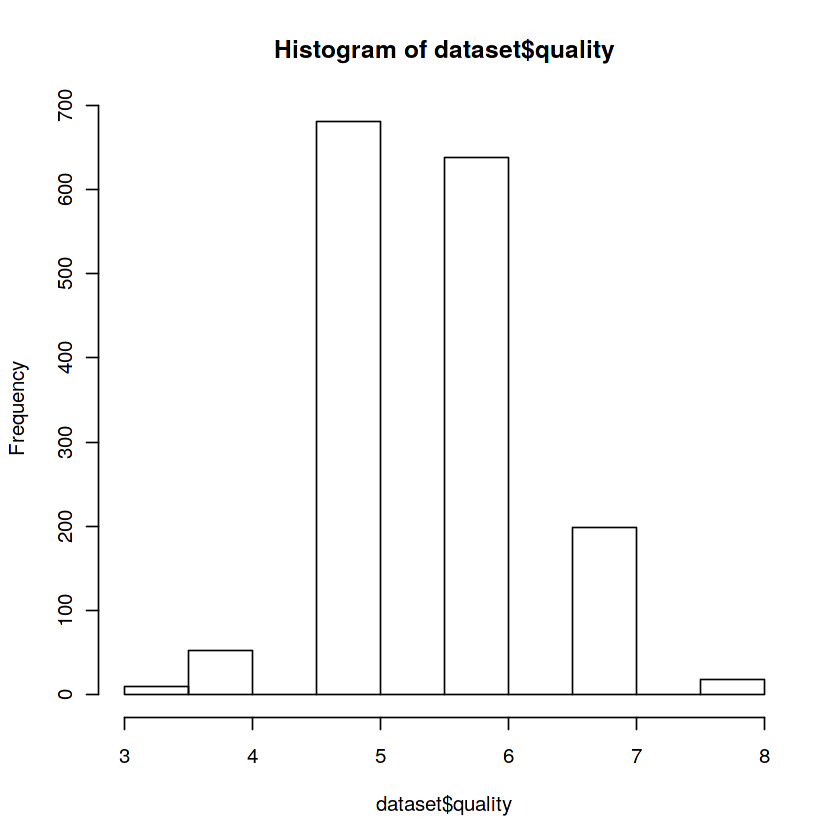

In [4]:
#Plot the distribution of quality data.
hist(dataset$quality)

From the histogram, we can see the imbalance of the data and this might influence our machine learning result.

I'm going to predict the quality of the wine based on its other features. 
First I factor the quality feature because it should not be continous but categorical.

In [5]:
dataset$quality = factor(dataset$quality)
# We examine the proportion of each quality again.
prop.table(table(dataset$quality))


          3           4           5           6           7           8 
0.006253909 0.033145716 0.425891182 0.398999375 0.124452783 0.011257036 

First I will do decision tree on the original data.

In [6]:
# Split the data to training_set and test_set using caTools.
library(caTools)
set.seed(123)
split = sample.split(dataset, SplitRatio = 0.66)
training_set = subset(dataset, split == TRUE)
test_set = subset(dataset, split == FALSE)
prop.table(table(training_set$quality))



          3           4           5           6           7           8 
0.006430868 0.035369775 0.408360129 0.413719185 0.123258307 0.012861736 

In [7]:
# Build decision tree on the training set and predict on test data
library(rpart)
model_control = rpart.control(xval = 10, cp = 0.00001)
fit_original = rpart(quality ~.,control = model_control, data = training_set )
pred_test_ori = predict(fit_original, newdata = test_set, type = "class")
cm = table(test_set$quality, pred_test_ori)
cm

   pred_test_ori
      3   4   5   6   7   8
  3   1   1   1   1   0   0
  4   0   1   8  10   1   0
  5   2   4 179 111   4   0
  6   1   4  64 162  21   0
  7   0   0  11  24  49   0
  8   0   0   0   3   3   0

Write a function to calculate the accuracy.

In [8]:
my_accuracy = function(table, total){
    n = dim(table)[1]
    sum = 0
    for (i in 1:n){
        sum = sum + table[i,i]
    }
    acc = sum/total
    return(acc)
}


In [9]:
acc_original_test = my_accuracy(cm, dim(test_set)[1])
acc_original_test

[1] 0.5885886

In [10]:
pred_train_ori = predict(fit_original, newdata = training_set,type="class")
cm2 = table(training_set$quality, pred_train_ori)
cm2

   pred_train_ori
      3   4   5   6   7   8
  3   3   0   1   2   0   0
  4   2   7  10  13   1   0
  5   2   6 296  73   4   0
  6   0   3  49 317  17   0
  7   0   1  13  28  73   0
  8   0   0   0   4   8   0

In [11]:
acc_original_training = my_accuracy(cm2, dim(training_set)[1])
acc_original_training

[1] 0.7459807

So obviously this result is overfitting. And the accuracy for test set is not good. 
Here I first binned those minority classes. Because  we may accept that the wine quality to be classified to 4 categories. Here I binned class 3 and class 4 to be class 4. I binned class 7 and class 8 to be class 7.

In [12]:
binned_data = data.frame(dataset)
binned_data = within(binned_data,{
  quality[quality == 3] = 4
  quality[quality == 8] = 7
})
binned_data$quality = factor(binned_data$quality,levels=c(4,5,6,7),labels = c('4','5','6','7'))
prop.table(table(binned_data$quality))


         4          5          6          7 
0.03939962 0.42589118 0.39899937 0.13570982 

By looking at the proportion table, the data is still not balanced so we can now try some techniques to make it balanced.

**Traditionally we have four ways to do this:**

**1. oversampling**

**2. undersampling**

**3. Synthetic Data Generation (smote)**

**4. cost sensitive learning**


I will try mehtod 1, 2, 3 here to find a best way to balance the data. For now I don't know how to decide the weights for each categories to increase the accuracy for the model, thus I didn't do method 4.

Again we need to split the data.

In [13]:
#split data
set.seed(123)
split = sample.split(binned_data, SplitRatio = 0.66)
binned_training_set = subset(binned_data, split == TRUE)
binned_test_set = subset(binned_data, split == FALSE)
prop.table(table(binned_training_set$quality))


         4          5          6          7 
0.04180064 0.40836013 0.41371919 0.13612004 

**Then I used upSample functions in caret pakage to oversample the data.**

In [14]:
library(caret)
upsample_data = upSample(binned_training_set,binned_training_set$quality)
head(upsample_data)

Loading required package: lattice


fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol,quality,Class
7.4,0.59,0.08,4.4,0.086,6,29,0.9974,3.38,0.50,9.0,4,4
5.7,1.13,0.09,1.5,0.172,7,19,0.9940,3.50,0.48,9.8,4,4
8.8,0.61,0.30,2.8,0.088,17,46,0.9976,3.26,0.51,9.3,4,4
4.6,0.52,0.15,2.1,0.054,8,65,0.9934,3.90,0.56,13.1,4,4
7.6,0.68,0.02,1.3,0.072,9,20,0.9965,3.17,1.08,9.2,4,4
7.3,0.55,0.03,1.6,0.072,17,42,0.9956,3.37,0.48,9.0,4,4


We can see the upSample function give us a newdata set where we have a extra feature "Class", so I will just delete the deature.

In [15]:
upsample_data$Class = NULL
prop.table(table(upsample_data$quality))


   4    5    6    7 
0.25 0.25 0.25 0.25 

In [16]:
#check the size of the upsample data and we can see the data increases a lot
dim(upsample_data)

[1] 1544   12

In [17]:
#create decision tree model on upsample data
#model_control = rpart.control(xval = 10, minsplit = 12, cp = 0.00001)
fit_upsample = rpart(quality ~.,control = model_control, data = upsample_data )

In [18]:
pred_upsample_test = predict(fit_upsample, newdata = binned_test_set, type = "class")
cm = table(binned_test_set$quality, pred_upsample_test)
pred_upsample_train = predict(fit_upsample, newdata = upsample_data,type="class")
cm2 = table(upsample_data$quality, pred_upsample_train)

In [19]:
paste('The accuracy for test set is ' , my_accuracy(cm,dim(binned_test_set)[1]))
paste('The accuracy for training set is ' , my_accuracy(cm2,dim(upsample_data)[1]))

[1] "The accuracy for test set is  0.539039039039039"

[1] "The accuracy for training set is  0.82059585492228"

The accuracy for test set is even worse here! So I can guess if I use downsample or smote I would have same problem. 
## So now I tried another tactics. I split my training data to new binned data which I will apply sampling techniques on and old binned data which I don’t change. I split my training data with 50% ratio and then apply oversampling to it and then merge it with old binned data to create a new training dataset.  ##


In [20]:
#Split the training data
split2 = sample.split(binned_training_set, SplitRatio = 0.5)
binned_new = subset(binned_data, split2 == TRUE)
binned_old = subset(binned_data, split2 == FALSE)
#oversample the new binned data
newdata1 = upSample(binned_new,binned_new$quality)
newdata1$Class = NULL
#merge oversampled new binned data with old binned data to create a new training set newdata1
upsample_data = rbind(newdata1,binned_old)


In [21]:
prop.table(table(upsample_data$quality))


        4         5         6         7 
0.1695469 0.3180757 0.3035965 0.2087809 

In [22]:
dim(upsample_data)

[1] 2141   12

By looking at the proportion table, I increase the minority data but not as many as before so the data won't be changed to much and then let's see how the model works!

In [23]:
#create decision tree model on new upsample data
model_control = rpart.control(xval = 10, minsplit = 12, cp = 0.00001)
fit_upsample = rpart(quality ~.,control = model_control, data = upsample_data )

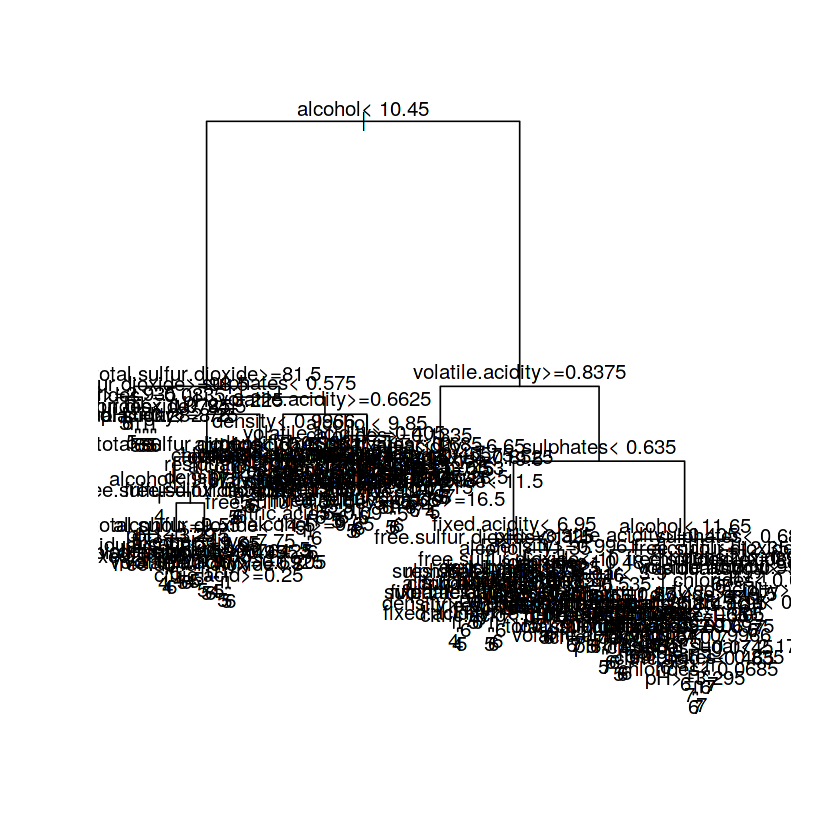

In [24]:
#plot the tree and I know it's a mess....
plot(fit_upsample)
text(fit_upsample)

In [25]:
pred_upsample_test = predict(fit_upsample, newdata = binned_test_set, type = "class")
cm = table(binned_test_set$quality, pred_upsample_test)
pred_upsample_train = predict(fit_upsample, newdata = upsample_data,type="class")
cm2 = table(upsample_data$quality, pred_upsample_train)
paste('The accuracy for test set is ' , my_accuracy(cm,dim(binned_test_set)[1]))
paste('The accuracy for training set is ' , my_accuracy(cm2,dim(upsample_data)[1]))

[1] "The accuracy for test set is  0.845345345345345"

[1] "The accuracy for training set is  0.872022419430173"

Great! This is not overfitting and the accuracy is much better for test set! If we wanna tune the parameters, just wuse the model_control there which is commented. Or maybe use other machine learning models to fit the data...
But now let's try downsample and smote very quickly.

In [26]:
#We can use DMwR to smote the data or we can use caret to smote the data when making the model.
library(DMwR)
split3 = sample.split(binned_training_set, SplitRatio = 0.5)
binned_new = subset(binned_data, split3 == TRUE)
binned_old = subset(binned_data, split3 == FALSE)
newdata1 = SMOTE(quality ~ ., prec.over =600,perc.under = 500, data = binned_new)
prop.table(table(newdata1$quality))
dim(newdata1)
newdata1 = rbind(newdata1,binned_old)
model_control = rpart.control(xval = 10, minsplit = 12, cp = 0.00001)
fit1 = rpart(quality ~.,control = model_control, data = newdata1 )
pred_fit1 = predict(fit1, newdata = binned_test_set, type = "class")
cm = table(binned_test_set$quality, pred_fit1)
pred_treebag_train = predict(fit1, newdata = newdata1,type="class")
cm2 = table(newdata1$quality, pred_treebag_train)
paste('The accuracy for test set is ' , my_accuracy(cm,dim(binned_test_set)[1]))
paste('The accuracy for training set is ' , my_accuracy(cm2,dim(newdata1)[1]))

Loading required package: grid



        4         5         6         7 
0.2307692 0.3341346 0.3221154 0.1129808 

[1] 416  12

[1] "The accuracy for test set is  0.741741741741742"

[1] "The accuracy for training set is  0.8125"

This looks not bad. But tuning the parameters for smote needs some previous experience, so I tried many pairs for prec.over and prec.under then to find an appropriate pair.

In [27]:
#downsample
split3 = sample.split(binned_training_set, SplitRatio = 0.5)
binned_new = subset(binned_data, split3 == TRUE)
binned_old = subset(binned_data, split3 == FALSE)
newdata1 = downSample(binned_training_set,binned_training_set$quality)
dim(newdata1)
newdata1$Class = NULL
newdata1 = rbind(newdata1,binned_old)
prop.table(table(newdata1$quality))

[1] 156  13


         4          5          6          7 
0.07861635 0.40041929 0.37421384 0.14675052 

In [28]:
fit1 = rpart(quality ~.,control = model_control, data = newdata1 )
pred_fit1 = predict(fit1, newdata = binned_test_set, type = "class")
cm = table(binned_test_set$quality, pred_fit1)
pred_treebag_train = predict(fit1, newdata = newdata1,type="class")
cm2 = table(newdata1$quality, pred_treebag_train)
paste('The accuracy for test set is ' , my_accuracy(cm,dim(binned_test_set)[1]))
paste('The accuracy for training set is ' , my_accuracy(cm2,dim(newdata1)[1]))

[1] "The accuracy for test set is  0.693693693693694"

[1] "The accuracy for training set is  0.805031446540881"

Downsampling is not good for this dataset according to the result above. 

To sum up, the best way in this case I think is to oversample part of the data.
====================================

Additional resources about using caret pakage
=========
Below I just want to show different ways to create decision tree and bagging techniques to help me classifiy the data. Since the oversample is good way to balance the data in this problem I will first repeat the above operations.

In [29]:
#Split the training data
split2 = sample.split(binned_training_set, SplitRatio = 0.5)
binned_new = subset(binned_data, split2 == TRUE)
binned_old = subset(binned_data, split2 == FALSE)
#oversample the new binned data
newdata1 = upSample(binned_new,binned_new$quality)
newdata1$Class = NULL
#merge oversampled new binned data with old binned data to create a new training set newdata1
upsample_data = rbind(newdata1,binned_old)
prop.table(table(upsample_data$quality))
dim(upsample_data)


        4         5         6         7 
0.1745027 0.3078662 0.3087703 0.2088608 

[1] 2212   12

Now I'm  gonna use train function in caret package. First to create trainControl to help us control the model.cI used treebag as the method. So it's like doing decision tree for two times and each time we did 10 fold cross validation. I just choose this arguments randomly. We can change the method to random forest as 'rf' and many other models. Read http://topepo.github.io/caret/index.html and find whatever you need.

In [30]:
control = trainControl(method = "repeatedcv",number = 10, repeats = 2)
#Then choose accuracy as out metric.
#By default, possible values are "RMSE" and "Rsquared" for regression and "Accuracy" and "Kappa" 
#for classification. 
metric = "Accuracy"
fit_upsample = train(quality ~., data = upsample_data, method = "treebag", metric = metric, trControl= control)

In [31]:
pred_upsample_test = predict(fit_upsample, newdata = binned_test_set)


In [32]:
cm = table(binned_test_set$quality, pred_upsample_test)


In [33]:
cm

   pred_upsample_test
      4   5   6   7
  4  24   0   0   0
  5   0 300   0   0
  6   0   0 252   0
  7   0   0   0  90

In [34]:
pred_upsample_train = predict(fit_upsample, newdata = upsample_data)
cm2 = table(upsample_data$quality, pred_upsample_train)
paste('The accuracy for test set is ' , my_accuracy(cm,dim(binned_test_set)[1]))
paste('The accuracy for training set is ' , my_accuracy(cm2,dim(upsample_data)[1]))

[1] "The accuracy for test set is  1"

[1] "The accuracy for training set is  0.999547920433996"

WOW! The accuracy is so high for both test and training set. This is similar to what random forest does though.

Apply Sampling techniques while building the model
=
Then I wanna show how to oversample, downsample or smote during the model building process not do it in advance. 
But I don't know how to control what proportion of data I wanna change to balance in this way. Just show how train function works.

In [35]:
control = trainControl(method = "repeatedcv",number = 10, repeats = 2)
metric = "Accuracy"
control$sampling = "smote"
fit1 = train(quality ~., data = binned_training_set, method = "treebag", metric = metric, trControl= control)
pred_fit1 = predict(fit1, newdata = binned_test_set)
cm = table(binned_test_set$quality, pred_fit1)
pred_treebag_train = predict(fit1, newdata = binned_training_set)
cm2 = table(binned_training_set$quality, pred_treebag_train)
paste('The accuracy for test set is ' , my_accuracy(cm,dim(binned_test_set)[1]))
paste('The accuracy for training set is ' , my_accuracy(cm2,dim(binned_training_set)[1]))

[1] "The accuracy for test set is  0.481981981981982"

[1] "The accuracy for training set is  0.554126473740622"

In [36]:
cm

   pred_fit1
      4   5   6   7
  4  11  10   3   0
  5  77 156  65   2
  6  40  68 129  15
  7   6  13  46  25

In [37]:
cm2

   pred_treebag_train
      4   5   6   7
  4  39   0   0   0
  5  94 225  60   2
  6  59  94 213  20
  7   5  20  62  40

Apprarently the result is bad! Now change to oversample.

In [38]:
control$sampling = "up"
fit1 = train(quality ~., data = binned_training_set, method = "treebag", metric = metric, trControl= control)
pred_fit1 = predict(fit1, newdata = binned_test_set)
cm = table(binned_test_set$quality, pred_fit1)
pred_treebag_train = predict(fit1, newdata = binned_training_set)
cm2 = table(binned_training_set$quality, pred_treebag_train)
paste('The accuracy for test set is ' , my_accuracy(cm,dim(binned_test_set)[1]))
paste('The accuracy for training set is ' , my_accuracy(cm2,dim(binned_training_set)[1]))

[1] "The accuracy for test set is  0.660660660660661"

[1] "The accuracy for training set is  0.997856377277599"

Overfitting for this one.....Needless to say the downsample won't give us good result.

Now control the smote in my way. But I don't know right now how to control oversample, maybe I will add it later when I find out. While I think just do it as a preprocessing is also convient. 

In [39]:
smoteest = list(name = "SMOTE my way",
                func = function(x, y){
                  library(DMwR)
                  dat = if (is.data.frame(x)) x else as.data.frame(x)
                  dat$.y = y
                  dat = SMOTE(.y ~., data = dat, k = 5, perc.over = 600, perc.under = 1000)
                  list(x = dat[,!grepl(".y", colnames(dat),fixed = TRUE)],
                       y = dat$.y)
                },
                first = TRUE)
control = trainControl(method = "repeatedcv",number = 10, repeats = 2)
fit1 = train(quality ~., data = binned_training_set, method = "treebag", metric = metric, trControl= control)
pred_fit1 = predict(fit1, newdata = binned_test_set)
cm = table(binned_test_set$quality, pred_fit1)
pred_treebag_train = predict(fit1, newdata = binned_training_set)
cm2 = table(binned_training_set$quality, pred_treebag_train)
paste('The accuracy for test set is ' , my_accuracy(cm,dim(binned_test_set)[1]))
paste('The accuracy for training set is ' , my_accuracy(cm2,dim(binned_training_set)[1]))

[1] "The accuracy for test set is  0.666666666666667"

[1] "The accuracy for training set is  0.997856377277599"

Just a little bit better than other result.